<a href="https://colab.research.google.com/github/bereml/riiaa-19-dmtl/blob/master/notebooks/2_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red convolucional

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo realizaremos un repaso rápido de como implementar una red convolucional para clasificación binaria.

Emplearemos una versión reducida de [Recipes5k](http://www.ub.edu/cvub/recipes5k/), un conjunto de imágenes de comida multietiquetado.

![Recipes5k](https://raw.githubusercontent.com/richardtml/riiaa-19-dmtl/master/figs/recipes5k.jpg)

## 1 Carga de datos

### 1.1 Importando bibliotecas

In [1]:
# para cargar Tensorflow 2 en Colab
try:
  %tensorflow_version 2.x
except Exception:
  pass


import os
# listar el sistema de archivos
import glob

# graficación
import matplotlib.pyplot as plt
import numpy as np
# lectura de csv
import pandas as pd
# redes neuronales
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D


# fijamos una semilla para reproducibilidad
tf.random.set_seed(42)

### 1.2 Descarga de los datos

In [2]:
tf.keras.utils.get_file('recipes2k.tar.gz',
    'https://cloud.xibalba.com.mx/s/AmF7Xa8F522qZnX/download',
    extract=True)
!ls ~/.keras/datasets/recipes2k

test  train  train.csv


### 1.3 Lectura de rutas y etiquetas

In [3]:
# leemos las rutas de las imágenes
images_paths = sorted(glob.glob(os.path.expanduser('~/.keras/datasets/recipes2k/train/*/*.jpg')))
images_paths[:5]

['/home/bere/.keras/datasets/recipes2k/train/apple_pie/0_spiced_apple_lattice_pie.jpg',
 '/home/bere/.keras/datasets/recipes2k/train/apple_pie/10_apple_pie.jpg',
 '/home/bere/.keras/datasets/recipes2k/train/apple_pie/11_classic_apple_pie.jpg',
 '/home/bere/.keras/datasets/recipes2k/train/apple_pie/12_magically_fast_apple_pie.jpg',
 '/home/bere/.keras/datasets/recipes2k/train/apple_pie/13_mug_apple_pie.jpg']

In [4]:
# leemos el csv de etiquetas
df = pd.read_csv('~/.keras/datasets/recipes2k/train.csv', sep=',')
df.head(5)

,item,healthy,junk,dessert,appetizer,mains,soups,carbs,protein,fats,meat
0,apple_pie,0,0,1,0,0,0,1,0,1,0
1,baby_back_ribs,0,0,0,0,1,0,0,1,1,1
2,beef_tacos,0,0,0,0,1,0,1,1,1,1
3,beet_salad,1,0,0,0,1,0,0,1,0,0
4,bread_pudding,0,0,1,0,0,0,1,0,1,0


In [5]:
# armamos un diccionario con la clase como llave y la primera etiqueta como valor  
labels_dict = {row[0]: row[1:2] for row in df.values}
# armamos una lista de de etiquetas para las rutas 
labels = [labels_dict[p.split('/')[-2]] for p in images_paths] 
labels[:5]

[array([0], dtype=object),
 array([0], dtype=object),
 array([0], dtype=object),
 array([0], dtype=object),
 array([0], dtype=object)]

### 1.4 Tuberia de datos

In [6]:
# tamaño a redimensionar para la imagen 
IMG_SIZE = (64, 64)
# función de lectura que toma una ruta y devuelve una imagen
def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image /= 255.0
    return image, label


shuffle_size = len(images_paths)
batch_size = 32

# cargamos las rutas y las etiquetas en un Dataset
train_ds = tf.data.Dataset.from_tensor_slices((images_paths, labels))
# barajeamos solo las rutas y las etiquetas
train_ds = train_ds.shuffle(shuffle_size)
# cargamos las imágenes de las rutas
train_ds = train_ds.map(read_image, num_parallel_calls=4)
# empaquetamos por lotes
train_ds = train_ds.batch(batch_size)

# imprimimos las dimensiones y un ejemplo
for x, y_true in train_ds:
    print('x.shape={}'.format(x.shape))
    print('x[0, :2, :2, 0]={}'.format(x[0, :2, :2, 0]))
    print('y_true.shape={}'.format(y_true.shape))
    print('y_true[0]={}'.format(y_true[0]))
    break

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
x.shape=(32, 64, 64, 3)
x[0, :2, :2, 0]=[[0.3920037  0.34561887]
 [0.33314952 0.39635417]]
y_true.shape=(32, 1)
y_true[0]=[0]


### 1.5 Exploración

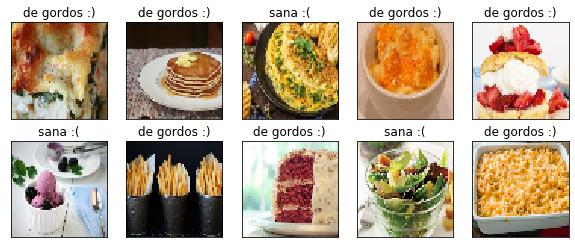

In [7]:
fig = plt.figure(figsize=(10, 4))
for i, (x, y_true) in enumerate(train_ds, start=1):
    ax = fig.add_subplot(2, 5, i)
    image = x[0]
    label = y_true[0][0].numpy()
    ax.imshow(image)
    ax.set_title('sana :(' if label else 'de gordos :)')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 10:
        break

## 2 Implementación del modelo

In [8]:
class VanillaCNN(tf.keras.Model):

  def __init__(self):
    super(VanillaCNN, self).__init__()
    self.conv1 = Conv2D(8, 3, padding='same')
    self.pool1 = MaxPooling2D(pool_size=2, padding='same')
    self.conv2 = Conv2D(16, 3, padding='same')
    self.pool2 = MaxPooling2D(pool_size=2, padding='same')
    self.conv3 = Conv2D(32, 3, padding='same')
    self.pool3 = MaxPooling2D(pool_size=2, padding='same')
    self.conv4 = Conv2D(64, 3, padding='same')
    self.pool4 = MaxPooling2D(pool_size=2, padding='same')
    self.flat = Flatten()
    self.fc = Dense(1)

  def call(self, x):
    #####################
    # (N, 64, 64, 3) =>
    # (N, 64, 64, 8)
    x = self.conv1(x)
    # (N, 64, 64, 8) =>
    # (N, 32, 32, 8)
    x = self.pool1(x)
    # (N, 32, 32, 8)
    x = tf.nn.relu(x)
    #####################
    # (N, 32, 32, 8) =>
    # (N, 32, 32, 16)
    x = self.conv2(x)
    # (N, 32, 32, 16) =>
    # (N, 16, 16, 16)
    x = self.pool2(x)
    # (N, 16, 16, 16)
    x = tf.nn.relu(x)
    #####################
    # (N, 16, 16, 16) =>
    # (N, 16, 16, 32)
    x = self.conv3(x)
    # (N, 16, 16, 32) =>
    # (N, 8, 8, 32)
    x = self.pool3(x)
    # (N, 8, 8, 32)
    x = tf.nn.relu(x)
    #####################
    # (N, 8, 8, 32) =>
    # (N, 8*8*32)
    x = self.flat(x)
    #####################
    # (N, 8*8*32) =>
    # (N, 1)
    x = self.fc(x)
    # (N, 1)
    x = tf.nn.sigmoid(x)
    return x

## 3 Entrenamiento

### 3.1 Función de pérdida y optimizador

In [9]:
# entropía cruzada binaria
loss_fn = tf.keras.losses.BinaryCrossentropy()
# gradiente descendente
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

### 3.2 Métricas: pérdida y exactitud

In [10]:
# historiales a nivel época
loss_epoch = tf.keras.metrics.Mean()
acc_epoch = tf.keras.metrics.BinaryAccuracy()

# historiales a nivel entrenamiento
loss_history = []
acc_history = []

### 3.3 Ciclo de entrenamiento

In [11]:
# instanciamos el modelo
model = VanillaCNN()

# épocas de entrenamiento
for epoch in range(25):
    # pasos de entrenamiento
    for step, (x, y_true) in enumerate(train_ds):
    
        # registramos el flujo del cómputo en GradientTape
        with tf.GradientTape() as tape:
            
            # realizamos inferencia con el lote 
            y_pred = model(x)
            # computamos la pérdia
            loss = loss_fn(y_true, y_pred)
        
        # computamos los gradientes de los parámetros del modelo
        gradients = tape.gradient(loss, model.trainable_weights)
        # aplicamos los gradientes
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        # calculamos las métricas y agramos al historial de la época
        loss_epoch(loss)
        acc_epoch(y_true, y_pred)
    
    # guardamos las métricas de la época
    loss_epoch_res = loss_epoch.result().numpy() * 100
    acc_epoch_res = acc_epoch.result().numpy() * 100
    
    # reiniciamos los historiales de las épocas
    loss_epoch.reset_states()
    acc_epoch.reset_states()
    
    # agreagmos a los historiales nivel entrenamiento
    loss_history.append(loss_epoch_res)
    acc_history.append(acc_epoch_res)
    
    # imprimimos métricas
    print('{:2d} loss={:6.2f}, acc={:6.2f}'.format(
        epoch, loss_epoch_res, acc_epoch_res))

 0 loss= 54.00, acc= 78.29
 1 loss= 52.39, acc= 78.29
 2 loss= 51.13, acc= 78.29
 3 loss= 50.86, acc= 78.54
 4 loss= 50.12, acc= 78.43
 5 loss= 47.95, acc= 79.17
 6 loss= 47.29, acc= 79.53
 7 loss= 45.97, acc= 80.45
 8 loss= 44.37, acc= 80.96
 9 loss= 43.77, acc= 81.44
10 loss= 41.68, acc= 81.73
11 loss= 40.57, acc= 82.50
12 loss= 38.90, acc= 83.41
13 loss= 36.56, acc= 84.11
14 loss= 34.96, acc= 85.17
15 loss= 33.48, acc= 85.50
16 loss= 31.36, acc= 87.22
17 loss= 28.64, acc= 88.50
18 loss= 26.82, acc= 89.31
19 loss= 24.56, acc= 90.22
20 loss= 21.70, acc= 91.65
21 loss= 20.43, acc= 92.42
22 loss= 18.63, acc= 93.12
23 loss= 16.63, acc= 94.21
24 loss= 14.67, acc= 94.69


### 3.4 Gráfica de pérdida

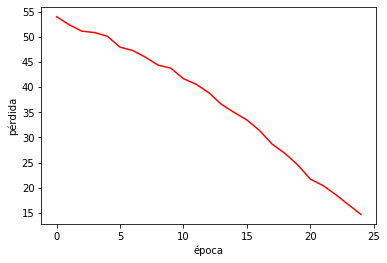

In [12]:
plt.plot(loss_history, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

### 3.5 Gráfica de exactitud

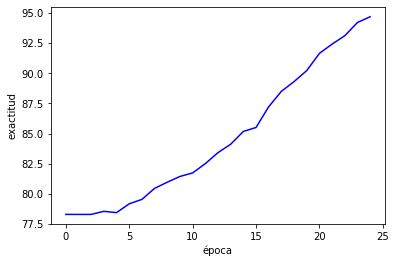

In [13]:
plt.plot(acc_history, color='blue')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

### 3.6 Curva ROC

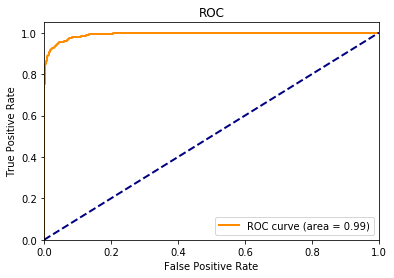

In [14]:
y_true, y_scor = [], []
for x, y_true_batch in train_ds:
    y_true.extend(y_true_batch.numpy().flatten())
    y_scor.extend(model(x).numpy().flatten())
y_true = np.array(y_true).astype(int)
y_scor = np.array(y_scor)

fpr, tpr, _ = roc_curve(y_true, y_scor)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 4 Prueba de la vitamina T

### 4.1 Tuberia de datos

In [15]:
def read_only_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image /= 255.0
    return image

images_paths = sorted(glob.glob(os.path.expanduser('~/.keras/datasets/recipes2k/test/*.jpg')))
images_ds = tf.data.Dataset.from_tensor_slices(images_paths).map(read_only_image, num_parallel_calls=4)
ds = tf.data.Dataset.zip(images_ds).shuffle(shuffle_size).batch(1)

### 4.2 Inferencia

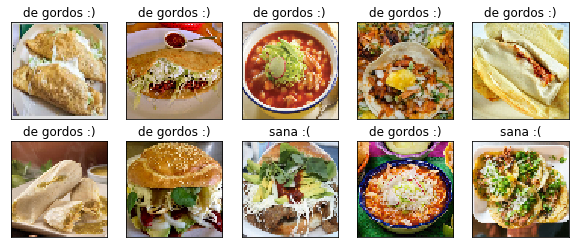

In [16]:
fig = plt.figure(figsize=(10, 4))
for i, (x) in enumerate(ds, start=1):
    ax = fig.add_subplot(2, 5, i)
    image = x[0]
    y_pred = model(x)
    label = int(round(y_pred[0][0].numpy()))
    ax.imshow(image)
    ax.set_title('sana :(' if label else 'de gordos :)')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 10:
        break